# Reuters News 다중 분류

In [1]:
import numpy as np
import tensorflow as tf
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

In [3]:
(X_train, y_train), (X_test, y_test) = reuters.load_data()
len(X_train), len(X_test)

2110848/2110848 [==============================] - 0s 0us/step


(8982, 2246)

In [4]:
# 카테고리 갯수
max(y_train) + 1

46

In [5]:
# 첫번째 뉴스
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
type(reuters.get_word_index())

550378/550378 [==============================] - 0s 0us/step


dict

In [7]:
reuters.get_word_index()['the']

1

In [8]:
index_word = {}
for key, value in reuters.get_word_index().items():
    index_word[value] = key
len(index_word)

30979

In [9]:
# 첫번째 기사 복원
' '.join(index_word[index] for index in X_train[0])

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [10]:
# 뉴스 기사의 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(2376, 145.5398574927633)

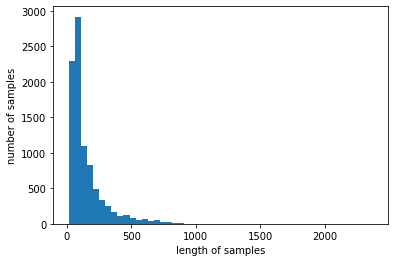

In [11]:
# 뉴스 기사 단어수의 분포
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

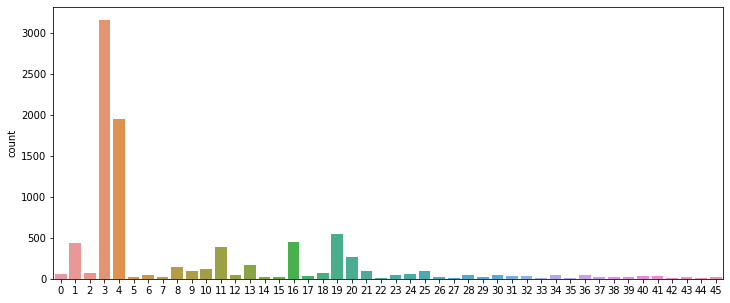

In [12]:
# 뉴스 그룹의 분포
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,5))
sns.countplot(y_train);

### LSTM으로 로이터 뉴스 분류
- 문장 길이: 120 단어 (최대: 2,376)
- 단어 빈도수: 빈도수 기준 3,000 단어 (총단어수: 30,979)

In [13]:
max_words = 3000
max_len = 120
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=max_words, test_split=0.2
)

In [14]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [15]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 120), (2246, 120), (8982, 46), (2246, 46))

In [16]:
model = Sequential([ 
    Embedding(max_words, 64, input_length=max_len),
    LSTM(100),
    Dense(46, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 64)           192000    
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 46)                4646      
                                                                 
Total params: 262,646
Trainable params: 262,646
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

In [18]:
model_path = 'best_model.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

In [19]:
hist = model.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=100, batch_size=128, callbacks=[mc, es]
)

Epoch 1/100
56/57 [============================>.] - ETA: 0s - loss: 2.7488 - accuracy: 0.3468
Epoch 1: val_loss improved from inf to 2.41875, saving model to best_model.h5
57/57 [==============================] - 8s 27ms/step - loss: 2.7483 - accuracy: 0.3466 - val_loss: 2.4188 - val_accuracy: 0.3450
Epoch 2/100
53/57 [==========================>...] - ETA: 0s - loss: 2.3904 - accuracy: 0.3547
Epoch 2: val_loss improved from 2.41875 to 2.31243, saving model to best_model.h5
57/57 [==============================] - 1s 13ms/step - loss: 2.3789 - accuracy: 0.3559 - val_loss: 2.3124 - val_accuracy: 0.3450
Epoch 3/100
56/57 [============================>.] - ETA: 0s - loss: 2.1437 - accuracy: 0.4826
Epoch 3: val_loss improved from 2.31243 to 2.04682, saving model to best_model.h5
57/57 [==============================] - 1s 13ms/step - loss: 2.1430 - accuracy: 0.4827 - val_loss: 2.0468 - val_accuracy: 0.4825
Epoch 4/100
55/57 [===========================>..] - ETA: 0s - loss: 2.0324 - accur

In [20]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 6ms/step - loss: 1.3742 - accuracy: 0.6665


[1.3742092847824097, 0.6665182709693909]

- 시각화

In [22]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

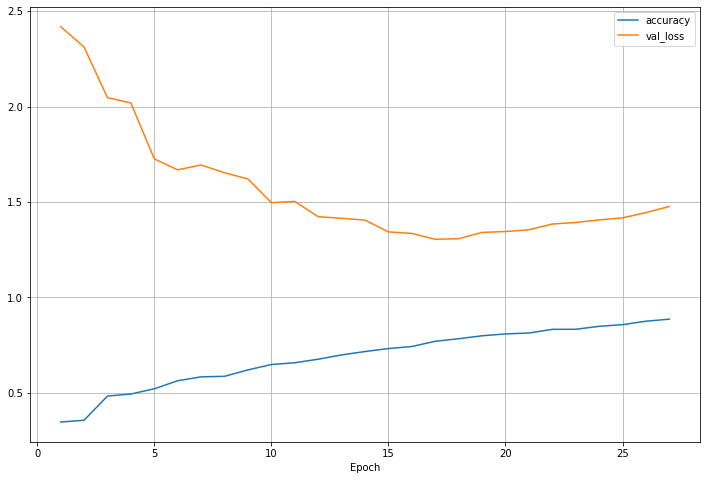

In [24]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='accuracy')
plt.plot(xs, y_vloss, label='val_loss')
plt.legend(), plt.grid()
plt.xlabel('Epoch')
plt.show()

### 다음의 각 케이스로 연습
- LSTM, GRU, SimpleRNN
- 문장 길이: 100, 120, 150
- 최대 단어: 1000, 3000, 10000
- Embedding vector 차원: 48, 64, 100
- Unit 갯수: 80, 100, 150